# 종합실습 1. CAR

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

matplotlib.rc("font",family="NanumGothic")
matplotlib.rc("axes",unicode_minus=False)

import graphviz

from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot
import statsmodels.api as sm
import scipy.stats

from sklearn.tree import export_graphviz
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import math

import warnings
warnings.filterwarnings("ignore")


## 데이터 불러오기 및 확인

In [2]:
df_raw = pd.read_csv('./datasets/Car.csv',encoding='euc-kr')
display(df_raw)
display(df_raw.info())

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.6 kmpl,998 CC,58.16 bhp,5.0,NaN
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7248,Volkswagen Vento Diesel Trendline,Hyderabad,NaN,2011,89411,Diesel,Manual,First,20.54 kmpl,1598 CC,103.6 bhp,5.0,NaN
7249,Volkswagen Polo GT TSI,Mumbai,NaN,2015,59000,Petrol,Automatic,First,17.21 kmpl,1197 CC,103.6 bhp,5.0,NaN
7250,Nissan Micra Diesel XV,Kolkata,NaN,2012,28000,Diesel,Manual,First,23.08 kmpl,1461 CC,63.1 bhp,5.0,NaN
7251,Volkswagen Polo GT TSI,Pune,NaN,2013,52262,Petrol,Automatic,Third,17.2 kmpl,1197 CC,103.6 bhp,5.0,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7253 non-null   object 
 1   Location           7253 non-null   object 
 2   Price              6200 non-null   float64
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   object 
 9   Engine             7207 non-null   object 
 10  Power              7207 non-null   object 
 11  Seats              7200 non-null   float64
 12  New_Price          1006 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 736.8+ KB


None

### 데이터 확인결과
- 7253 개의 행과 13개의 칼럼으로 구성되어 있으며 일부 결측값이 나타남을 알 수 있다.
- 타겟변수는 중고차가격(Price) 로 연속형 변수이다.

## 중복값 확인 및 제거

In [3]:
# 중복값 확인
df_raw.duplicated().sum()

1

In [4]:
df_raw[df_raw.duplicated()==True]

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
6582,Honda City 1.5 E MT,Mumbai,NaN,2010,52000,Petrol,Manual,First,17.0 kmpl,1497 CC,118 bhp,5.0,NaN


In [5]:
# 중복값 제거
df_raw.drop(index=6582, inplace=True)
df_raw.duplicated().sum()

0

### 중복값 처리 결과
- 중복값은 총 7253 개 행에서 6258번째 행의 값이 중복값으로 나타났으며 1개의 행은 모델링에 영향이 적을 것으로 판단하여 drop 처리

## 결측치 확인 및 데이터 정제

In [6]:
df_raw.isnull().sum().sort_values(ascending=False)

New_Price            6246
Price                1052
Seats                  53
Engine                 46
Power                  46
Mileage                 2
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
dtype: int64

- 신차 가격(New_Price) 와 타겟 변수 중고차가격(Price) 에 결측치가 많은 것을 확인
- 이때 신차 가격(New_Price) 의 경우 결측치가 매우 높으므로 분석 데이터에서 제외함
- 다음 변수 차의 좌석수(Seats), 엔진의 배기량(Engine), 엔진최대출력(Power), 자동차회사제공 표준주행거리(Mileage) 에 결측치를 확인

- 어떻게 처리할 것인가? -> 데이터 정제화를 통해 결측치 처리방법을 알아본다.

In [7]:
# New_Price 삭제
df_raw.drop(columns = ["New_Price"], inplace = True)

In [8]:
df_raw[df_raw['Power'].isnull()].head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
194,Honda City 1.5 GXI,Ahmedabad,4522.23,2007,60006,Petrol,Manual,First,0.0 kmpl,NaN,NaN,NaN
208,Maruti Swift 1.3 VXi,Kolkata,3234.55,2010,42001,Petrol,Manual,First,16.1 kmpl,NaN,NaN,NaN
733,Maruti Swift 1.3 VXi,Chennai,2682.68,2006,97800,Petrol,Manual,Third,16.1 kmpl,NaN,NaN,NaN
749,Land Rover Range Rover 3.0 D,Mumbai,40623.44,2008,55001,Diesel,Automatic,Second,0.0 kmpl,NaN,NaN,NaN
1294,Honda City 1.3 DX,Delhi,4905.47,2009,55005,Petrol,Manual,First,12.8 kmpl,NaN,NaN,NaN


- 타겟 변수인 중고차가격(Price) 결측치의 경우, 알수없음
- Seats 와 Engine, Power, Mileage 의 경우 데이터를 통해 알아보아야 한다.

In [9]:
# 단위와 표현되어 있는 수치형 변수 처리
df_raw['Mileage'] = df_raw['Mileage'].str.replace('kmpl', '')
df_raw['Engine'] = df_raw['Engine'].str.replace('CC', '')
df_raw['Power'] = df_raw['Power'].str.replace('bhp', '')

In [10]:
# 단위를 나타내지 않는 변수를 변환을 위해 zero 값 처리
df_raw['Mileage'] = df_raw['Mileage'].str.replace('null', '0')
df_raw['Engine'] = df_raw['Engine'].str.replace('null', '0')
df_raw['Power'] = df_raw['Power'].str.replace('null', '0')

In [11]:
# object data type을 category data type 으로 변경
df_raw['Location'] = df_raw['Location'].astype('category')
df_raw['Fuel_Type'] = df_raw['Fuel_Type'].astype('category')
df_raw['Transmission'] = df_raw['Transmission'].astype('category')
df_raw['Owner_Type'] = df_raw['Owner_Type'].astype('category')

In [12]:
# object data tyoe을 float data type 으로 변경
df_raw['Mileage'] = df_raw['Mileage'].astype('float')
df_raw['Engine'] = df_raw['Engine'].astype('float')
df_raw['Power'] = df_raw['Power'].astype('float')

In [13]:
display(df_raw.head())
display(df_raw.info())

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0


<class 'pandas.core.frame.DataFrame'>
Index: 7252 entries, 0 to 7252
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Name               7252 non-null   object  
 1   Location           7252 non-null   category
 2   Price              6200 non-null   float64 
 3   Year               7252 non-null   int64   
 4   Kilometers_Driven  7252 non-null   int64   
 5   Fuel_Type          7252 non-null   category
 6   Transmission       7252 non-null   category
 7   Owner_Type         7252 non-null   category
 8   Mileage            7250 non-null   float64 
 9   Engine             7206 non-null   float64 
 10  Power              7206 non-null   float64 
 11  Seats              7199 non-null   float64 
dtypes: category(4), float64(5), int64(2), object(1)
memory usage: 539.1+ KB


None

In [14]:
# data가 0인 data 결측값 처리
df_raw.loc[df_raw.Mileage == 0, 'Mileage'] = np.nan
df_raw.loc[df_raw.Engine == 0, 'Engine'] = np.nan
df_raw.loc[df_raw.Power == 0, 'Power'] = np.nan
df_raw[df_raw['Engine'].isnull()].head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
194,Honda City 1.5 GXI,Ahmedabad,4522.23,2007,60006,Petrol,Manual,First,NaN,NaN,NaN,NaN
208,Maruti Swift 1.3 VXi,Kolkata,3234.55,2010,42001,Petrol,Manual,First,16.1,NaN,NaN,NaN
733,Maruti Swift 1.3 VXi,Chennai,2682.68,2006,97800,Petrol,Manual,Third,16.1,NaN,NaN,NaN
749,Land Rover Range Rover 3.0 D,Mumbai,40623.44,2008,55001,Diesel,Automatic,Second,NaN,NaN,NaN,NaN
1294,Honda City 1.3 DX,Delhi,4905.47,2009,55005,Petrol,Manual,First,12.8,NaN,NaN,NaN


- 결측치에 대해 drop, mean 대체, median 대체 중 가장 적합한 방법을 찾기위해 시각화를 이용하여 알아본다 

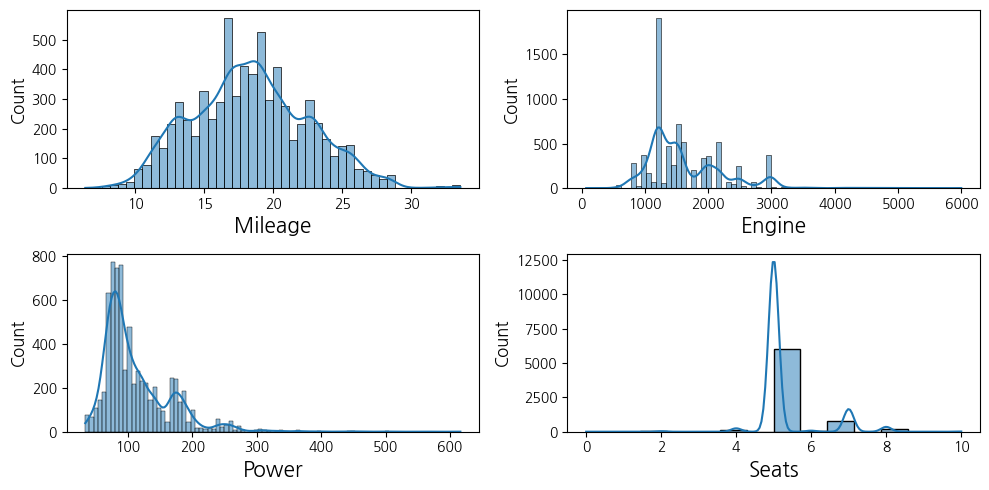

In [15]:
df_nacol = df_raw[['Mileage', 'Engine', 'Power', 'Seats']]

plt.figure(figsize=(10, 5))
for i, idx in enumerate(df_nacol.columns):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data=df_nacol[idx], kde=True)
    plt.xlabel(idx, fontsize=15)
    plt.ylabel("Count", fontsize=12)
    plt.tight_layout()

plt.show()

### 결측치 처리 결과
- 다음 Mileage , Seats 을 제외하고 Engine, Power 변수는 왼쪽에 치우친 분포이므로 평균값을 대체하는 것은 적절하지 않다
- 즉, 중앙값을 대체하여 분석을 진행한다.
- 타겟 변수(Price) 의 결측치는 모델링 과정에서 성능을 높이기 위해 타겟변수를 drop 처리함

In [16]:
# 결측치에 대해 중앙값으로 대체 처리
df_raw['Mileage'] = df_raw['Mileage'].fillna(df_raw['Mileage'].median())
df_raw['Engine'] = df_raw['Engine'].fillna(df_raw['Engine'].median())
df_raw['Power'] = df_raw['Power'].fillna(df_raw['Power'].median())
df_raw['Seats'] = df_raw['Seats'].fillna(df_raw['Seats'].median())

In [17]:
# 타겟 변수 Price 결측치 제거 : 설명변수가 아닌 타겟변수는 모델링 과정에서 성능을 낮출 수 있어 drop 처리함
df_raw.dropna(subset=['Price'], inplace=True)

In [18]:
df_raw.isna().sum().sort_values(ascending=False)

Name                 0
Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
dtype: int64

- 위와 같이 데이터의 결측치를 처리한 모습을 알 수 있다.

## 데이터 정제(파생변수 생성 및 id변수 제거)

In [19]:
# 'Name'변수에서 Brand 명 추출(파생변수 생성)
df_raw['Brand'] = df_raw['Name'].apply(lambda x : x.split()[0])

In [20]:
# Brand 파생변수의 고유값 수
df_raw['Brand'].nunique()

30

In [21]:
# 'Name'변수 제거
df_raw.drop(columns=['Name'], inplace = True)

In [22]:
# 'Year'변수에서 Car_age 추출(파생변수 생성)
# Car_age 변수 파생 : 현재 연도와 나이 열을 새로 생성함 현재 연도는 2023년 
# 연령 열은 자동차 나이 = 현재연도 - 연식
df_raw['Current_year'] = 2023
df_raw['Car_age'] = df_raw['Current_year'] - df_raw['Year']
df_raw.drop(columns = ['Current_year'], axis = 1, inplace = True)
df_raw.head()

,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Car_age
0,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,Maruti,13
1,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,Hyundai,8
2,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,Honda,12
3,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,Maruti,11
4,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,Audi,10


In [23]:
target_col = ['Price']
cat_cols = ['Location','Fuel_Type','Transmission','Owner_Type','Brand']
con_cols = ['Year','Kilometers_Driven','Mileage','Engine','Power','Seats','Car_age']

In [24]:
display(df_raw.head())
display(df_raw.info())

,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Car_age
0,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,Maruti,13
1,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,Hyundai,8
2,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,Honda,12
3,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,Maruti,11
4,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,Audi,10


<class 'pandas.core.frame.DataFrame'>
Index: 6200 entries, 0 to 7236
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Location           6200 non-null   category
 1   Price              6200 non-null   float64 
 2   Year               6200 non-null   int64   
 3   Kilometers_Driven  6200 non-null   int64   
 4   Fuel_Type          6200 non-null   category
 5   Transmission       6200 non-null   category
 6   Owner_Type         6200 non-null   category
 7   Mileage            6200 non-null   float64 
 8   Engine             6200 non-null   float64 
 9   Power              6200 non-null   float64 
 10  Seats              6200 non-null   float64 
 11  Brand              6200 non-null   object  
 12  Car_age            6200 non-null   int64   
dtypes: category(4), float64(5), int64(3), object(1)
memory usage: 509.5+ KB


None

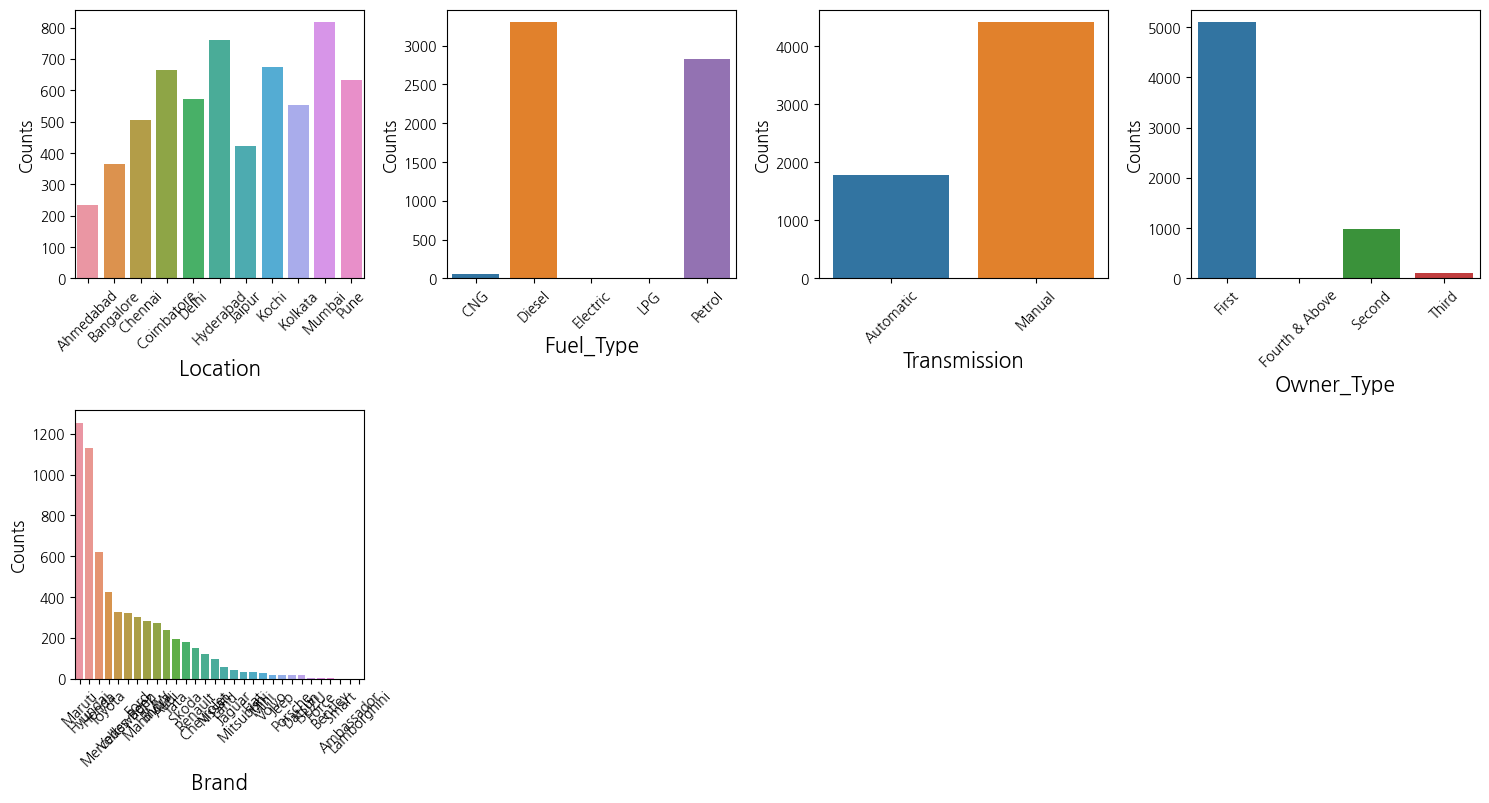

In [25]:
plt.figure(figsize=(15, 15))
for i, column in enumerate(cat_cols):
    plt.subplot(4, 4, i + 1)
    sns.barplot(x=df_raw[column].value_counts().index, y=df_raw[column].value_counts(), fill=True)
    plt.xlabel(column, fontsize=15)
    plt.ylabel("Counts", fontsize=12)
    plt.xticks(rotation=45)  # x축 레이블 회전
    plt.tight_layout()

plt.show()

## 이상치 확인 및 데이터 정제

In [26]:
df_raw['Price'].sort_values(ascending=False)

4079    245273.60
5781    183955.20
5919    153296.00
1505    148804.43
1974    143592.36
          ...    
2847       689.83
1628       689.83
3138       689.83
1713       674.50
7236         7.08
Name: Price, Length: 6200, dtype: float64

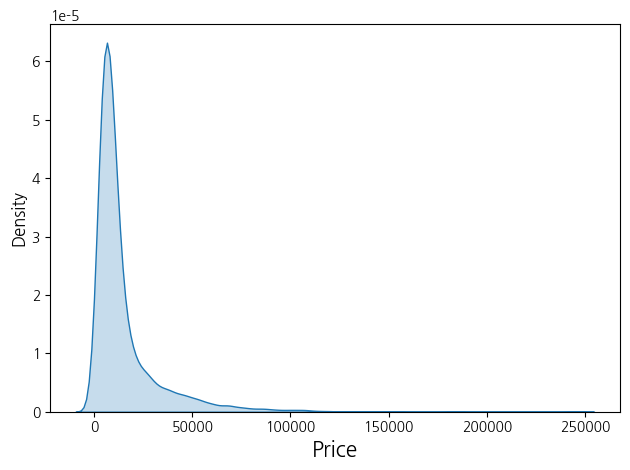

In [27]:
# 타겟 변수 Price 데이터 분포 확인
sns.kdeplot(df_raw['Price'], fill=True)
plt.xlabel('Price', fontsize=15)
plt.ylabel("Density", fontsize=12)
plt.tight_layout()

<Axes: >

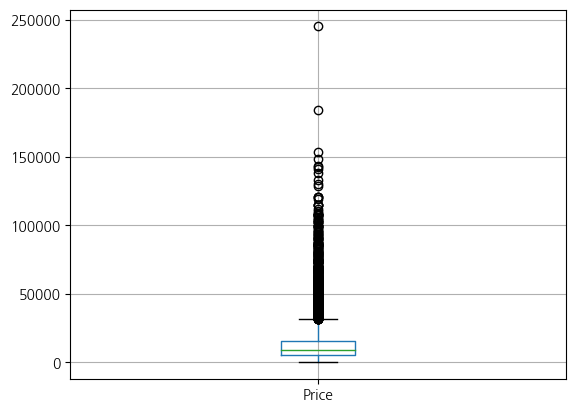

In [28]:
# 타겟 변수 Price 데이터 상자그림 확인
df_raw.boxplot('Price')

- 1. 평균을 기준으로 산포되어있어야하나 데이터 분포가 오른쪽으로 치우쳐져 있어 이상치가 있을 것이라고 추정됨
- 2. 중고차 가격의 최소값이 7.08 으로 극단적인 이상치로 보일 뿐만아니라 3sigma 를 충분히 넘으므로 drop 처리를 한다.

In [29]:
df_raw.drop(index=7236, inplace=True)
df_raw = df_raw[df_raw['Price'] < df_raw['Price'].mean() + (3 * df_raw['Price'].std())]

In [30]:
df_raw['Price'].sort_values(ascending=False)

1138    67450.24
2515    67450.24
598     67450.24
311     67450.24
1537    67450.24
          ...   
2605      766.48
2847      689.83
3138      689.83
1628      689.83
1713      674.50
Name: Price, Length: 6043, dtype: float64

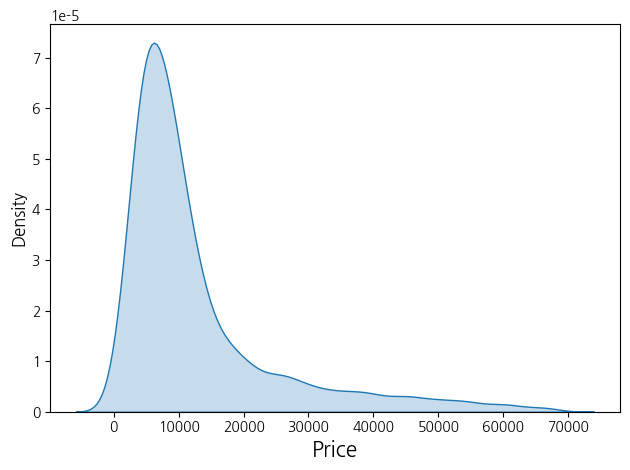

In [31]:
sns.kdeplot(df_raw['Price'], fill=True)
plt.xlabel('Price', fontsize=15)
plt.ylabel("Density", fontsize=12)
plt.tight_layout()

<Axes: >

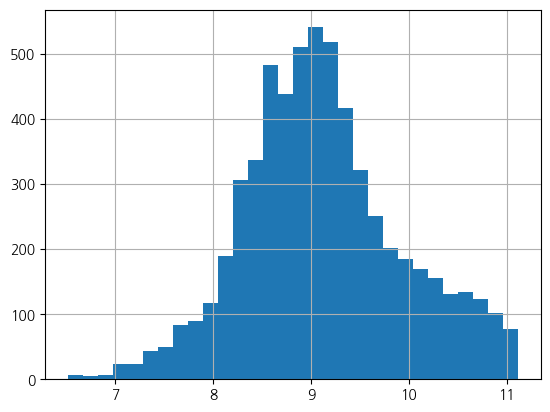

In [32]:
# Price log 변환 및 정규성 확인
df_raw['Price'] = np.log(df_raw['Price'])
df_raw['Price'].hist(bins = 30)

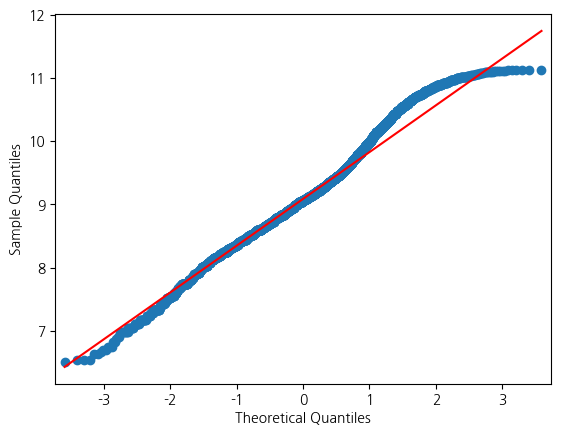

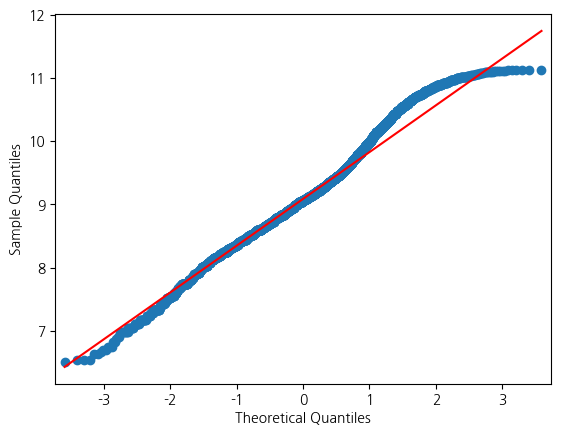

In [33]:
# 잔차 정규성 검정 : QQplot, s-standardized line
# r-regressionline, q-quartiles
qqplot(df_raw['Price'], line = 'q')

- 타겟변수가 왼쪽으로 치우친 분포를 보임
- 타겟변수 정규화를 위해 log 변환을 실시함
- qqplot 을 통해 정규성 확인을 검토함

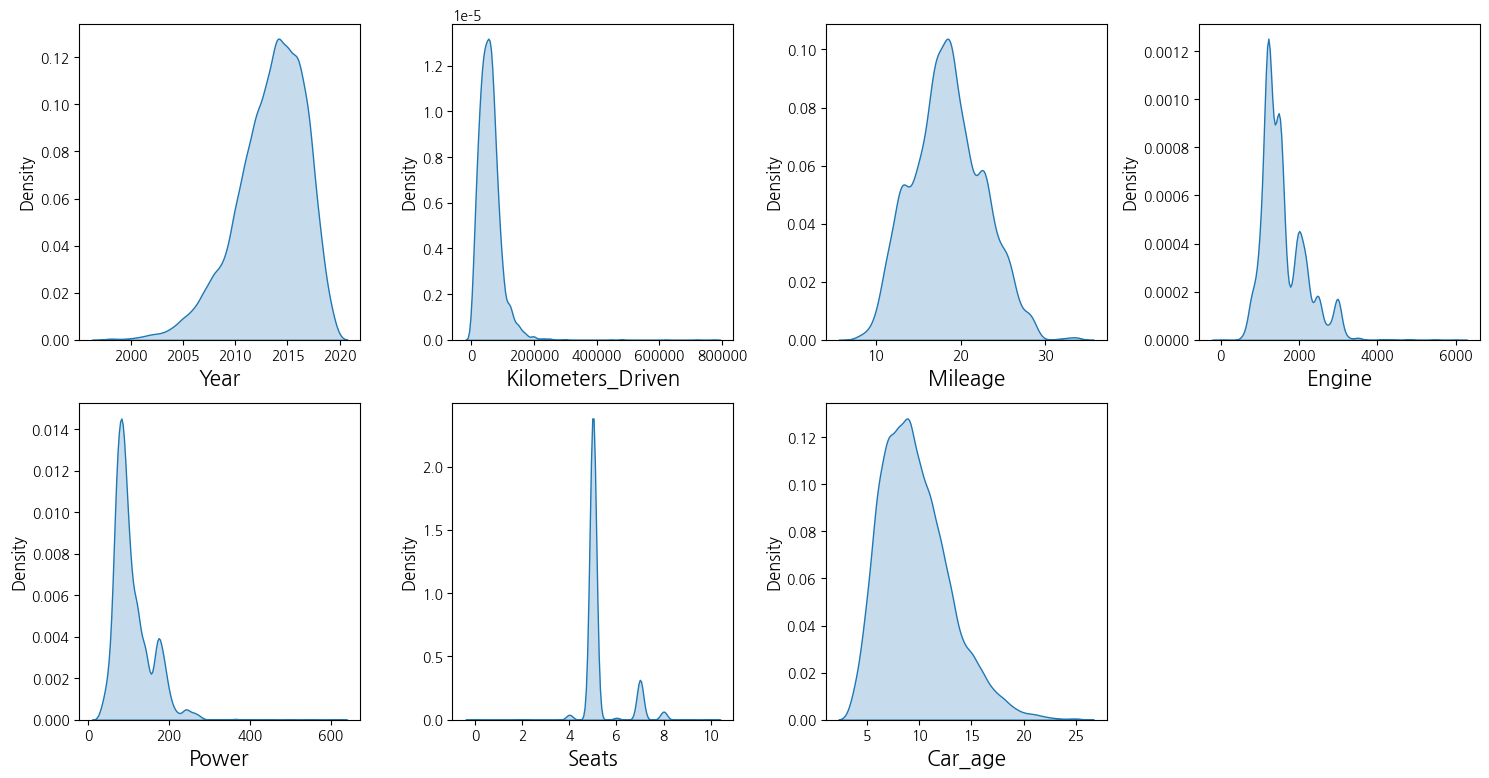

In [34]:
# 연속형 데이터의 분포 확인
plt.figure(figsize=(15, 15))
for i, idx in enumerate(con_cols):
    plt.subplot(4, 4, i + 1)
    sns.kdeplot(data=df_raw[idx], fill=True)
    plt.xlabel(idx, fontsize=15)
    plt.ylabel("Density", fontsize=12)
    plt.tight_layout()

plt.show()

In [35]:
print('엔진 배기량 : \n',df_raw['Engine'].sort_values())
print('엔진 최대출력 : \n',df_raw['Power'].sort_values())
print('이전 주행거리 : \n',df_raw['Kilometers_Driven'].sort_values())

엔진 배기량 : 
 4446      72.0
3157     624.0
2645     624.0
112      624.0
5468     624.0
         ...  
2100    4806.0
70      4806.0
152     5461.0
4722    5461.0
6354    5998.0
Name: Engine, Length: 6043, dtype: float64
엔진 최대출력 : 
 790      34.2
1008     34.2
1912     34.2
2849     34.2
3091     34.2
        ...  
4061    444.0
4627    450.0
70      500.0
2100    550.0
6354    616.0
Name: Power, Length: 6043, dtype: float64
이전 주행거리 : 
 1361       171
5606       600
2054      1000
1242      1000
173       1000
         ...  
3092    480000
2823    480000
358     620000
1860    720000
340     775000
Name: Kilometers_Driven, Length: 6043, dtype: int64


Text(0.5, 0, 'Variables')

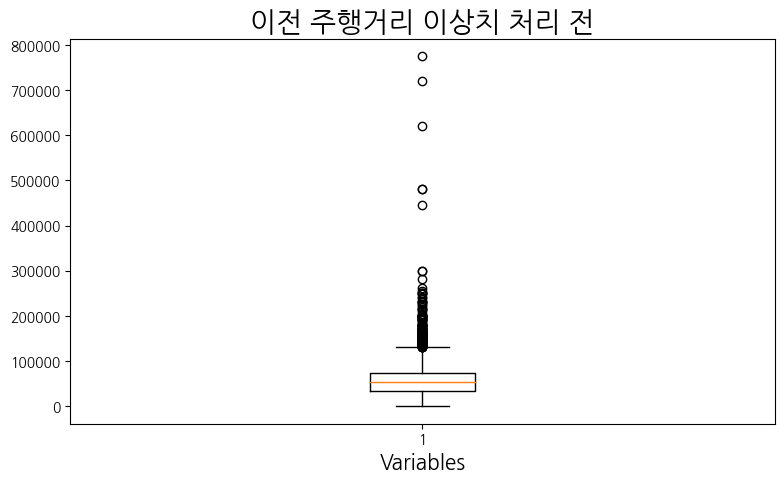

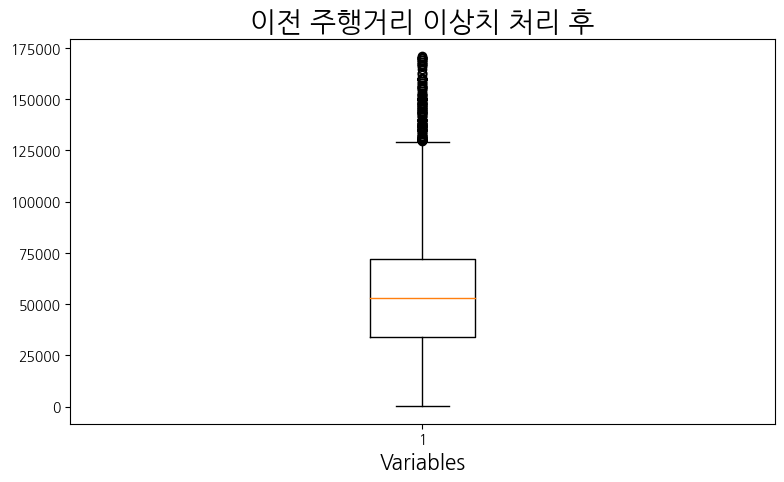

In [36]:
# 이전 주행거리(Kilometers_Driven) 이상치 처리
plt.figure(figsize=(20, 5))

# 이상치 처리 전의 boxplot 그리기
plt.subplot(1, 2, 1)
plt.boxplot(df_raw['Kilometers_Driven'])
plt.title('이전 주행거리 이상치 처리 전', size=20)
plt.xlabel('Variables', size=15)

df_raw = df_raw[df_raw['Kilometers_Driven'] < df_raw['Kilometers_Driven'].mean() + (3 * df_raw['Kilometers_Driven'].std())]

# 이상치 처리 후
plt.figure(figsize=(20, 5))

# 이상치 처리 전의 boxplot 그리기
plt.subplot(1, 2, 2)
plt.boxplot(df_raw['Kilometers_Driven'])
plt.title('이전 주행거리 이상치 처리 후', size=20)
plt.xlabel('Variables', size=15)

Text(0.5, 0, 'Variables')

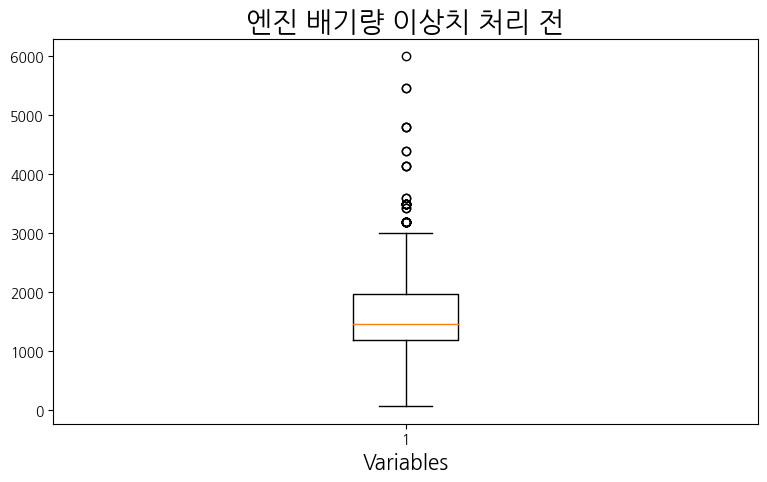

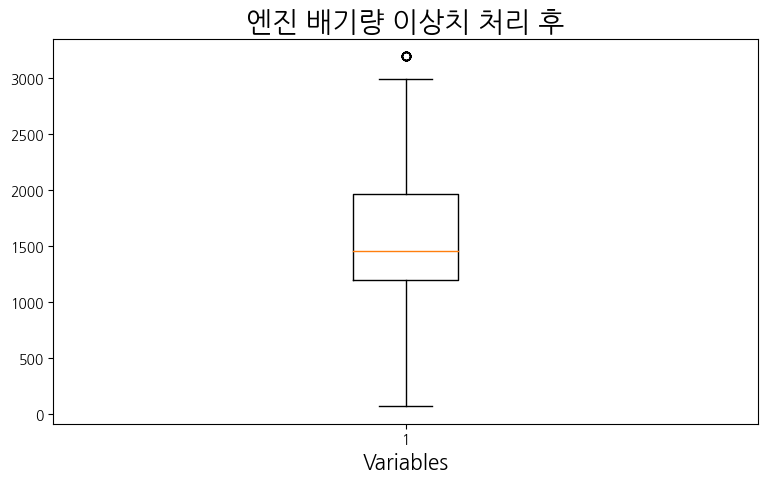

In [37]:
# 엔진 배기량(Engine) 이상치 처리
plt.figure(figsize=(20, 5))

# 이상치 처리 전의 boxplot 그리기
plt.subplot(1, 2, 1)
plt.boxplot(df_raw['Engine'])
plt.title('엔진 배기량 이상치 처리 전', size=20)
plt.xlabel('Variables', size=15)

df_raw = df_raw[df_raw['Engine'] < df_raw['Engine'].mean() + (3 * df_raw['Engine'].std())]

# 이상치 처리 후
plt.figure(figsize=(20, 5))

# 이상치 처리 전의 boxplot 그리기
plt.subplot(1, 2, 2)
plt.boxplot(df_raw['Engine'])
plt.title('엔진 배기량 이상치 처리 후', size=20)
plt.xlabel('Variables', size=15)

Text(0.5, 0, 'Variables')

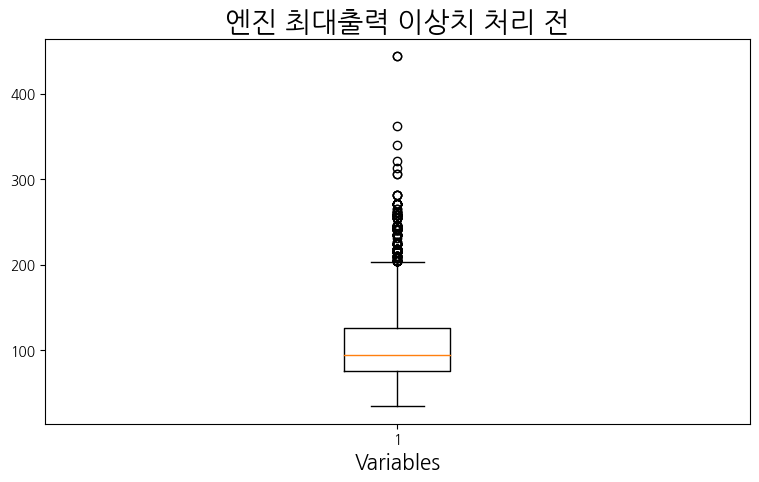

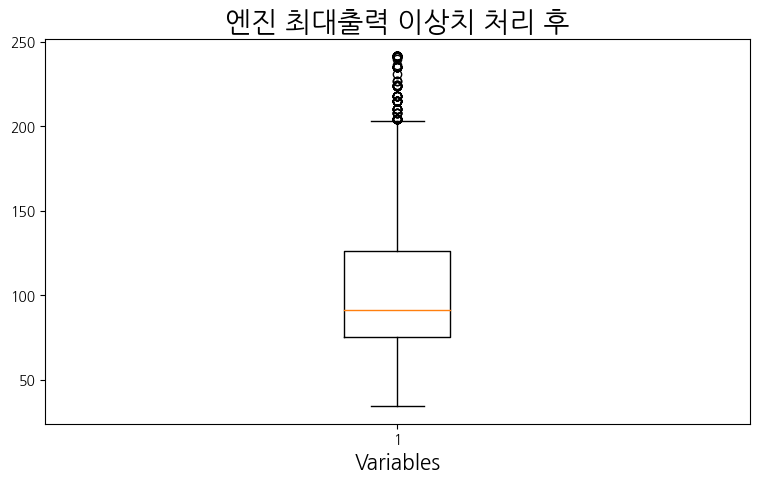

In [38]:
# 엔진 최대출력(Power) 이상치 처리
plt.figure(figsize=(20, 5))

# 이상치 처리 전의 boxplot 그리기
plt.subplot(1, 2, 1)
plt.boxplot(df_raw['Power'])
plt.title('엔진 최대출력 이상치 처리 전', size=20)
plt.xlabel('Variables', size=15)

df_raw = df_raw[df_raw['Power'] < df_raw['Power'].mean() + (3 * df_raw['Power'].std())]

# 이상치 처리 후
plt.figure(figsize=(20, 5))

# 이상치 처리 전의 boxplot 그리기
plt.subplot(1, 2, 2)
plt.boxplot(df_raw['Power'])
plt.title('엔진 최대출력 이상치 처리 후', size=20)
plt.xlabel('Variables', size=15)

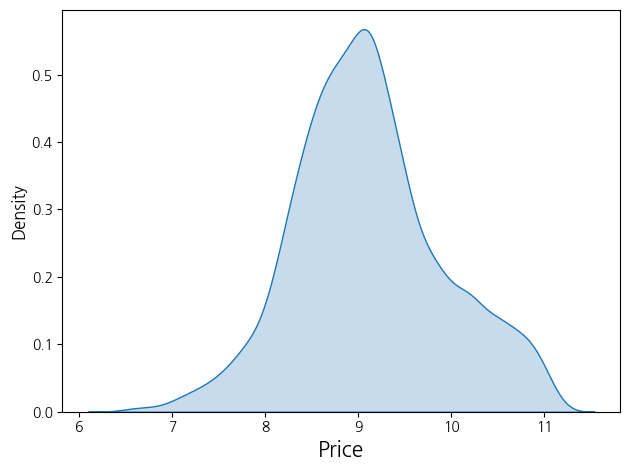

In [39]:
# 타겟 변수의 분포 확인
sns.kdeplot(df_raw['Price'], fill=True)
plt.xlabel('Price', fontsize=15)
plt.ylabel("Density", fontsize=12)
plt.tight_layout()

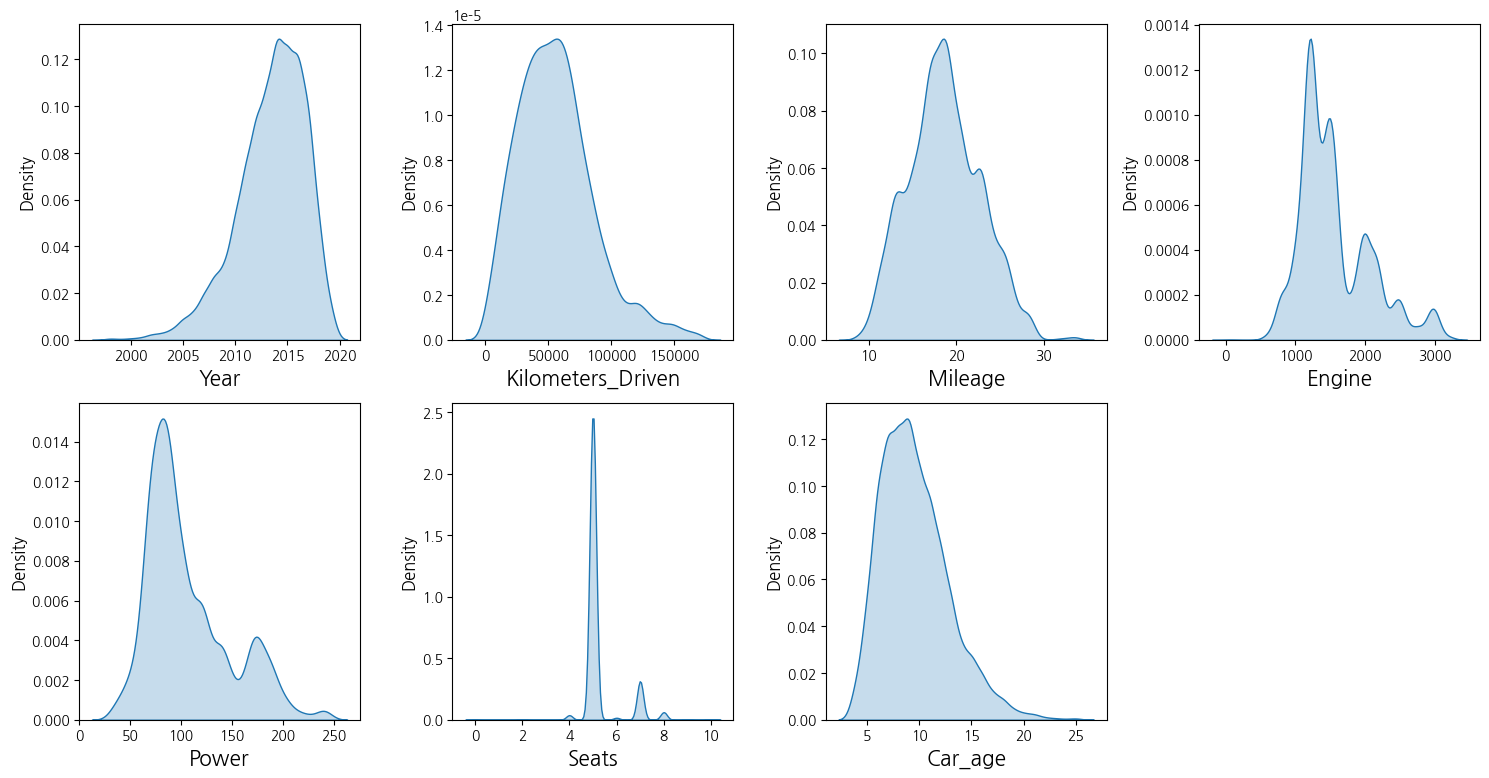

In [40]:
# 연속형 데이터의 분포 확인
plt.figure(figsize=(15, 15))
for i, idx in enumerate(con_cols):
    plt.subplot(4, 4, i + 1)
    sns.kdeplot(data=df_raw[idx], fill=True)
    plt.xlabel(idx, fontsize=15)
    plt.ylabel("Density", fontsize=12)
    plt.tight_layout()

plt.show()

<Axes: >

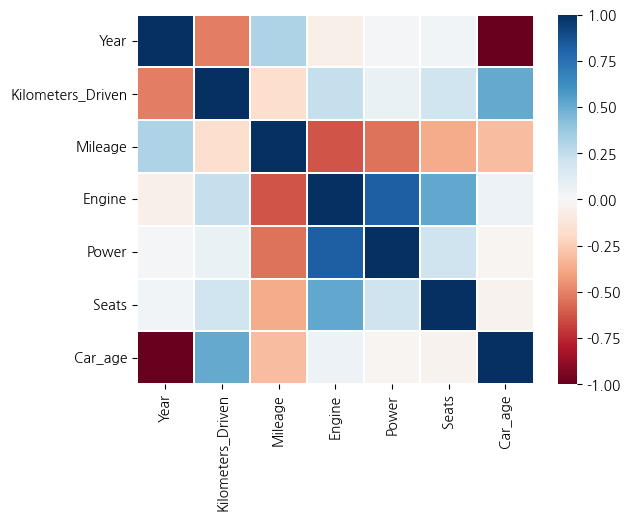

In [41]:
sns.heatmap(df_raw[con_cols].corr(),annot=False,cmap='RdBu',linewidths=0.2)

### 이상치 처리 결과
- 이상치 처리 전 과 후 target 변수(Price)와 이전 주행거리, 엔진 배기량, 엔진 최대출력 의 분포가 확실히 정규성을 따르는 모습을 보인다.

## 범주형 데이터의 더미화(label encording)

In [42]:
from sklearn.preprocessing import LabelEncoder
# 레이블 인코더 객체 생성
label_encoder = LabelEncoder()

# cat_cols에 있는 각 범주형 변수들에 대해 레이블 인코딩 수행
for col in cat_cols:
    df_raw[col] = label_encoder.fit_transform(df_raw[col])

# 결과 확인
print(df_raw[cat_cols])


      Location  Fuel_Type  Transmission  Owner_Type  Brand
0            9          0             1           0     15
1           10          1             1           0      9
2            2          4             1           0      8
3            2          1             1           0     15
4            3          1             0           2      1
...        ...        ...           ...         ...    ...
7224         2          4             1           0      4
7228        10          1             1           0     24
7231         7          4             1           0      7
7232         9          4             1           0     12
7235         7          1             1           0     15

[5892 rows x 5 columns]


In [43]:
display(df_raw.head())
display(df_raw.info())

,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Car_age
0,9,7.894572,2010,72000,0,1,0,26.60,998.0,58.16,5.0,15,13
1,10,9.860684,2015,41000,1,1,0,19.67,1582.0,126.20,5.0,9,8
2,2,8.839033,2011,46000,4,1,0,18.20,1199.0,88.70,5.0,8,12
3,2,9.126715,2012,87000,1,1,0,20.77,1248.0,88.76,7.0,15,11
4,3,10.210778,2013,40670,1,0,2,15.20,1968.0,140.80,5.0,1,10


<class 'pandas.core.frame.DataFrame'>
Index: 5892 entries, 0 to 7235
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           5892 non-null   int32  
 1   Price              5892 non-null   float64
 2   Year               5892 non-null   int64  
 3   Kilometers_Driven  5892 non-null   int64  
 4   Fuel_Type          5892 non-null   int32  
 5   Transmission       5892 non-null   int32  
 6   Owner_Type         5892 non-null   int32  
 7   Mileage            5892 non-null   float64
 8   Engine             5892 non-null   float64
 9   Power              5892 non-null   float64
 10  Seats              5892 non-null   float64
 11  Brand              5892 non-null   int32  
 12  Car_age            5892 non-null   int64  
dtypes: float64(5), int32(5), int64(3)
memory usage: 529.4 KB


None

## 데이터 분할

In [44]:
df_raw_y = df_raw['Price']

In [45]:
df_raw_x = df_raw.drop(['Price'],axis=1,inplace =False)

In [46]:
print('df_raw_y : \n',df_raw_y.head())
print('df_raw_x : \n',df_raw_x.head())

df_raw_y : 
 0     7.894572
1     9.860684
2     8.839033
3     9.126715
4    10.210778
Name: Price, dtype: float64
df_raw_x : 
    Location  Year  Kilometers_Driven  Fuel_Type  Transmission  Owner_Type  \
0         9  2010              72000          0             1           0   
1        10  2015              41000          1             1           0   
2         2  2011              46000          4             1           0   
3         2  2012              87000          1             1           0   
4         3  2013              40670          1             0           2   

   Mileage  Engine   Power  Seats  Brand  Car_age  
0    26.60   998.0   58.16    5.0     15       13  
1    19.67  1582.0  126.20    5.0      9        8  
2    18.20  1199.0   88.70    5.0      8       12  
3    20.77  1248.0   88.76    7.0     15       11  
4    15.20  1968.0  140.80    5.0      1       10  


In [47]:
# DT, RF, GB : train/test 를 6 : 4 비율로 분할
df_train_x, df_test_x , df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size=0.4)
print("train data size : {}".format(df_train_x.shape))
print("train data size : {}".format(df_train_y.shape))
print("test data size : {}".format(df_test_x.shape))
print("test data size : {}".format(df_test_y.shape))

train data size : (3535, 12)
train data size : (3535,)
test data size : (2357, 12)
test data size : (2357,)


## DecisionTreeRegressor

In [48]:
tree_uncustomized = DecisionTreeRegressor()
tree_uncustomized.fit(df_train_x, df_train_y)
#train / test 설명력
print('score on training set :', tree_uncustomized.score(df_train_x, df_train_y))
print('score on test set :', tree_uncustomized.score(df_test_x, df_test_y))

score on training set : 0.9999902843231203
score on test set : 0.8258130902547709


- custum 되지않은 모델의 설명력은 train 에서 99.9% , test 에서 78% 로 train 데이터 과대적합이다.
- 즉, 과대적합을 방지하기 위해 custom DT모델링을 실시한다.

In [49]:
tree_uncustomized.get_params() # 현재 생성된 트리 모델의 옵션 확인

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [50]:
# 모델 Parameter 조정
# train, test 설명력 결과 저장
train_score, test_score = [], []  # 괄호를 사용하여 변수 할당

# min_samples_leaf 잎사귀 최소 자료 수
para_leaf = [n_leaf for n_leaf in range(1, 20)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor( min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,0.825
1,2,0.981,0.836
2,3,0.966,0.847
3,4,0.955,0.848
4,5,0.942,0.856
5,6,0.935,0.858
6,7,0.928,0.863
7,8,0.922,0.860
8,9,0.918,0.863
9,10,0.914,0.860


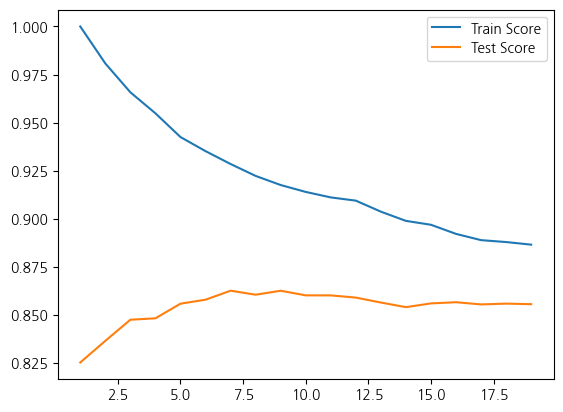

In [51]:
plt.plot(para_leaf, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = '-', label = 'Test Score')
plt.legend()

- 잎사귀 노드 최소 자료수 증가에 따라 train 데이터 모델의 설명력 감소
- train 데이터의 성능 최대 / test 데이터 성능 최대를 고려하여 모델링 옵션 MinSamplesLeaf = 10 으로 설정한다.

In [52]:
#train 및 test 설명력 결과 저장
train_score = []; test_score = []

# min_samples_split : 분리 노드의 최소 자료 수
para_split = [n_split * 2 for n_split in range(2, 20)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor( min_samples_leaf=10, min_samples_split = v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score
# 모델 설명력 확인
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.914,0.860
1,6,0.914,0.860
2,8,0.914,0.860
3,10,0.914,0.860
4,12,0.914,0.860
5,14,0.914,0.860
6,16,0.914,0.858
7,18,0.914,0.860
8,20,0.914,0.860
9,22,0.913,0.859


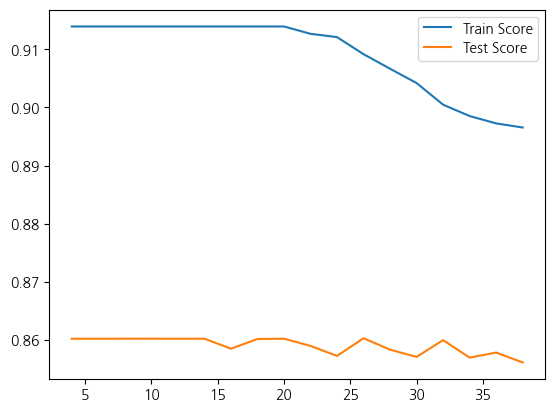

In [53]:
plt.plot(para_split, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_split, test_score, linestyle = '-', label = 'Test Score')
plt.legend()

- 분리 노드의 최소 자료수 증가에 따라 모델 설명력 감소, train 데이터 과적합 경향성이 나타남
- train / test 데이터 성능 변화를 고려하여 MinSamplesSplit = 25 선택

In [54]:
#train 및 test 설명력 결과 저장
train_score = []; test_score = []

# min_samples_split : 분리 노드의 최소 자료 수
para_depth = [depth for depth in range(1, 20)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor( min_samples_leaf=10, min_samples_split = 25, max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score
# 모델 설명력 확인
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.417,0.425
1,2,0.615,0.615
2,3,0.723,0.718
3,4,0.784,0.787
4,5,0.833,0.824
5,6,0.861,0.841
6,7,0.880,0.848
7,8,0.896,0.851
8,9,0.902,0.856
9,10,0.906,0.855


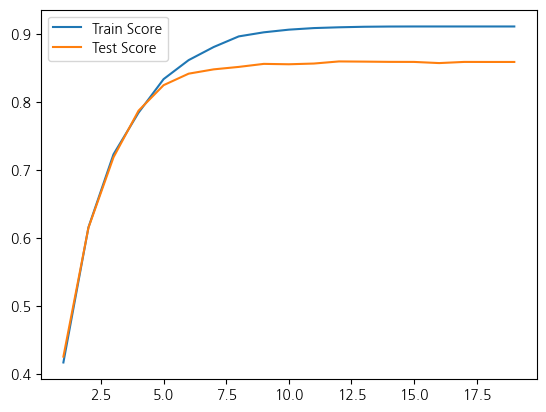

In [55]:
plt.plot(para_depth, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_depth, test_score, linestyle = '-', label = 'Test Score')
plt.legend()

- 최대 깊이 증가에 따라 train / test 모델의 설명력은 증가하며 성능의 최대치를 고려하여 max_depth = 10 을 선택함

In [56]:
# 최종 모델 선정
#변수명 저장
v_feature_name = df_train_x.columns

tree_final = DecisionTreeRegressor(min_samples_leaf=10, min_samples_split=25, max_depth = 10)
tree_final.fit(df_train_x, df_train_y)
tree_final.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 25,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [57]:
test_pred = tree_final.predict(df_test_x)
print('test data의 실제값 : \n', df_test_y[:10])
print('test data의 예측값 : \n', test_pred[:10])

test data의 실제값 : 
 5507     9.126715
1439     9.596719
4651     9.048754
4426     8.847883
667      9.175506
2238     8.433568
5075    10.702252
5181     8.843468
5000     9.002663
3747     9.414397
Name: Price, dtype: float64
test data의 예측값 : 
 [9.40212887 9.62730716 9.59538072 8.57342724 8.97074207 8.323677
 9.0502067  9.20369283 9.2093966  9.44213532]


In [58]:
#tree.feature_importances 로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

#df_feature_importance 의 테이블을 중요도별로 정렬
df_importance.sort_values('Importance', ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
8,Power,0.588
11,Car_age,0.250
7,Engine,0.058
1,Year,0.051
6,Mileage,0.013
10,Brand,0.011
4,Transmission,0.010
0,Location,0.010
2,Kilometers_Driven,0.006
3,Fuel_Type,0.003


Text(0, 0.5, '변수')

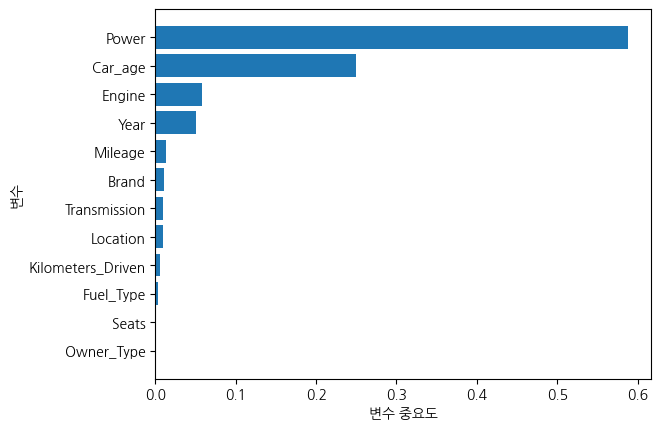

In [59]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace= True)
coordinates = range(len(df_importance))
plt.barh(y= coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

- 트리 분리에 영향이 큰 변수는 Power, Car_age, Mileage 순으로 중요하다고 나타나며
- 엔진 출력(Power) <= 142.5 이면 True(자료수 2888, 평균 중고차 가격이 감소(12599.353 -> 8610.766), MSE 감소)
- 엔진 출력(Power) > 142.5 이면 False(자료수 647, 평균 중고차 가격이 증가(12599.353 -> 30403.122), MSE 감소)
- 분리 조건이 좌측이 True, 우측이 False 적용
- 최대깊이가 증가하면서 생성되는 잎사귀(leaf)의 자료 수 감소, 모델의 MSE도 지속적으로 감소하지만 분리조건에 따라
- 평균 중고차 가격은 상위 노드 대비 증감이 있음

- 의사결정트리(Decision Tree) 분석 결과
- 중요 설명변수는 엔진 출력(Power), 차의 연식(Car_age), 표준 주행거리(Mileage) 순으로 영향이 크다고 해석이 가능하다
- 그리고 엔진 출력이 높을수록, 차의 연식이 적을수록, 표준 주행거리가 많을수록 타겟변수인 중고차 가격(Price)이 증가한다고 볼 수 있다.

In [60]:
print('score on training set :', tree.score(df_train_x, df_train_y))
print('score on test set :', tree.score(df_test_x, df_test_y))

score on training set : 0.9105033464170791
score on test set : 0.8583820548341047


## GradientBoosting

In [61]:
from sklearn.ensemble import GradientBoostingRegressor

- custum 되지 않은 GradientBoostingRegressor 모델

In [62]:
gb_model = GradientBoostingRegressor()
gb_model.fit (df_train_x, df_train_y)

GradientBoostingRegressor()

In [63]:
train_pred = gb_model.predict(df_train_x)
gb_model.score(df_train_x, df_train_y)
print('score on training set :', gb_model.score(df_train_x, df_train_y))
print('score on test set :', gb_model.score(df_test_x, df_test_y))

score on training set : 0.9243608188747787
score on test set : 0.9104207774527553


- custum 되지않은 GB 모델은 과적합 경향성이 보이며 test 데이터에서 91.0% 성능을 나타냄

In [64]:
test_pred = gb_model.predict(df_test_x)
gb_model.score(df_test_x, df_test_y)

0.9104207774527553

In [65]:
param_grid = {"max_depth" : range(2, 10, 2),
             "min_samples_split" : range(2, 40, 5),
             "min_samples_leaf" : range(2, 20, 5),
             "n_estimators" : range(2, 100, 10)}

- GB GridSearch 최적 파라미터 찾기

In [66]:
grid_gb = GridSearchCV(gb_model, param_grid, cv=2, n_jobs = -1)
grid_gb.fit(df_train_x, df_train_y)

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(2, 10, 2),
                         'min_samples_leaf': range(2, 20, 5),
                         'min_samples_split': range(2, 40, 5),
                         'n_estimators': range(2, 100, 10)})

In [67]:
print("best model: \n{}".format(grid_gb.best_estimator_))
print("\nbest parameter: \n{}".format(grid_gb.best_params_))
print("\nbest score: \n{}".format(grid_gb.best_score_.round(3)))
print("\nbest set score: \n{}".format(grid_gb.score(df_test_x,df_test_y).round(3)))

best model: 
GradientBoostingRegressor(max_depth=6, min_samples_leaf=2, min_samples_split=37,
                          n_estimators=92)

best parameter: 
{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 37, 'n_estimators': 92}

best score: 
0.911

best set score: 
0.928


- GradientBoosting -> GridSearchCV 결과 
- 잎사귀 노드 최소 자료수 = 2 , 분리 노드 최소 자료수 = 30 , 최대깊이 = 6 에서 최적화성능을 나타낸다

In [68]:
gb_final = GradientBoostingRegressor(n_estimators = 92 ,min_samples_leaf = 12, min_samples_split = 32, max_depth = 6)
gb_final.fit(df_train_x, df_train_y)

GradientBoostingRegressor(max_depth=6, min_samples_leaf=12,
                          min_samples_split=32, n_estimators=92)

In [69]:
print("Score on training set : {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
print("Score on test set : {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Score on training set : 0.961
Score on test set : 0.927


In [70]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = df_train_x.columns
df_importance["importance"] = gb_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,importance
8,Power,0.526
1,Year,0.169
11,Car_age,0.113
7,Engine,0.080
4,Transmission,0.026
10,Brand,0.024
0,Location,0.019
6,Mileage,0.015
2,Kilometers_Driven,0.014
3,Fuel_Type,0.009


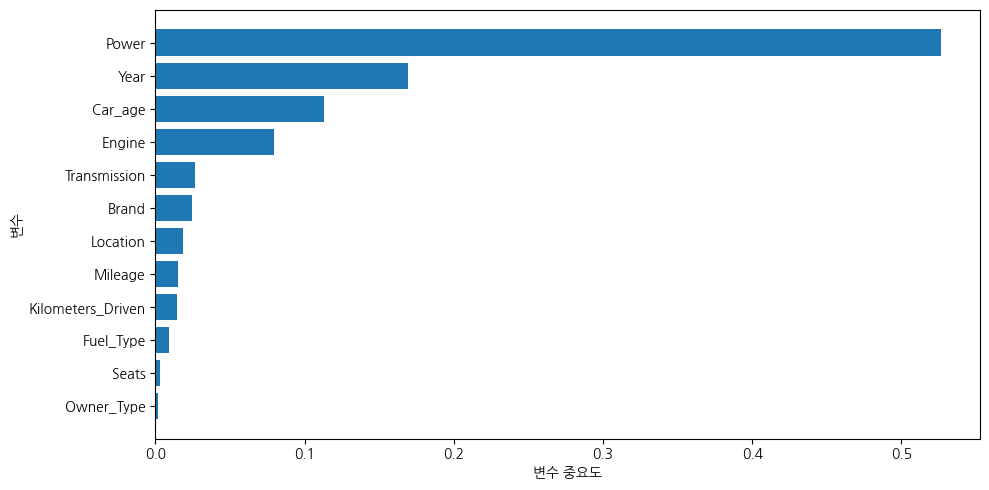

In [71]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))

plt.figure(figsize=(10, 5))
plt.barh(y=coordinates, width = df_importance["importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")
plt.tight_layout()

- GradientBoosting 분석 결과
- GradientBoosting 에 영향이 큰 변수는 Power, Year, Car_age, Engine 순으로 중요하다고 나타나며
- 중요 설명변수는 엔진 출력(Power), 출고년도(Year), 출고이후년수(Car_age) 순으로 영향이 크다고 해석이 가능하다
- 그리고 엔진 출력이 높을수록, 출고년도가 높을수록(최근일수록), 출고이후년수가 적을수록 타겟변수인 중고차 가격(Price)이 증가한다고 볼 수 있다.

## 성능 평가

In [72]:
def root_mean_squared_error(y_true, y_pred):
    squared_errors = [(true - pred) ** 2 for true, pred in zip(y_true, y_pred)]
    mean_squared_error = sum(squared_errors) / len(y_true)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    return root_mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    absolute_percentage_errors = [abs((true - pred) / true) * 100 for true, pred in zip(y_true, y_pred)]
    mean_absolute_percentage_error = sum(absolute_percentage_errors) / len(y_true)
    return mean_absolute_percentage_error


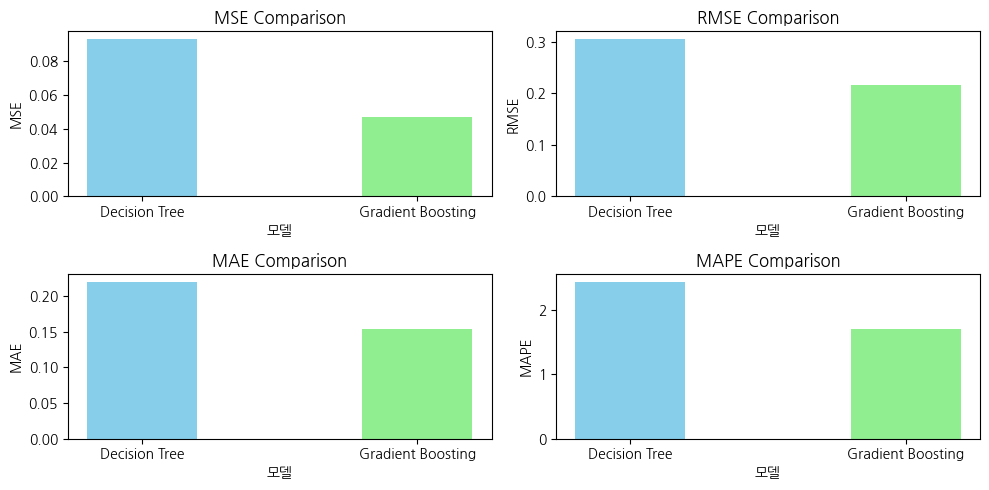

In [73]:
# 모델 이름들
model_names = ['Decision Tree', 'Gradient Boosting']

mse, rmse, mae, mape = [], [], [], []

# Decision Tree 모델 예측 및 평가
df_y_pred_dt = tree_final.predict(df_test_x)
mse.append(mean_squared_error(df_test_y, df_y_pred_dt))
rmse.append(root_mean_squared_error(df_test_y, df_y_pred_dt))
mae.append(mean_absolute_error(df_test_y, df_y_pred_dt))
mape.append(mean_absolute_percentage_error(df_test_y, df_y_pred_dt))

# Gradient Boosting 모델 예측 및 평가
df_y_pred_gb = gb_final.predict(df_test_x)
mse.append(mean_squared_error(df_test_y, df_y_pred_gb))
rmse.append(root_mean_squared_error(df_test_y, df_y_pred_gb))
mae.append(mean_absolute_error(df_test_y, df_y_pred_gb))
mape.append(mean_absolute_percentage_error(df_test_y, df_y_pred_gb))

# 평가 지표 값들
mse_values = [mse[0], mse[1]]
rmse_values = [rmse[0], rmse[1]]
mae_values = [mae[0], mae[1]]
mape_values = [mape[0], mape[1]]

# 막대 그래프를 그리기 위해 변수 설정
x = np.arange(len(model_names))

# 평가 지표별로 서브플롯 그리기
plt.figure(figsize=(10, 5))

# MSE 서브플롯
plt.subplot(2, 2, 1)
plt.bar(x, mse, width=0.4, color=['skyblue', 'lightgreen'])
plt.xticks(x, model_names)
plt.xlabel('모델')
plt.ylabel('MSE')
plt.title('MSE Comparison')

# RMSE 서브플롯
plt.subplot(2, 2, 2)
plt.bar(x, rmse, width=0.4, color=['skyblue', 'lightgreen'])
plt.xticks(x, model_names)
plt.xlabel('모델')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')

# MAE 서브플롯
plt.subplot(2, 2, 3)
plt.bar(x, mae, width=0.4, color=['skyblue', 'lightgreen'])
plt.xticks(x, model_names)
plt.xlabel('모델')
plt.ylabel('MAE')
plt.title('MAE Comparison')

# MAPE 서브플롯
plt.subplot(2, 2, 4)
plt.bar(x, mape, width=0.4, color=['skyblue', 'lightgreen'])
plt.xticks(x, model_names)
plt.xlabel('모델')
plt.ylabel('MAPE')
plt.title('MAPE Comparison')

# 서브플롯 간 간격 조절
plt.tight_layout()
plt.show()

## 결론
- GradientBoosting 분석 결과에서는 엔진 출력, 출고년수, 출고이후년수, 엔진 배기량 순으로 중요하다고 나타냈고
- 의사결정트리(Decision Tree) 분석 결과 중요 설명변수는 엔진 출력, 출고이후년수, 표준 주행거리 순으로 중요하다고 나타냈다.
- 그렇다면 두 모델링의 성능은 어떻게 될까?

- 두 모델링에서 공통적으로 중요한 변수는 엔진 출력, 출고이후년수 가 중요한 변수라고 나타냈다
- 즉, 엔진 출력, 출고이후년수는 중고차 시세에 큰 영향을 미치며 엔진 출력이 클수록, 출고이후년수가 적을수록 중고차 가격은 올라간다
- 중고차 시세는 엔진 출력과 시간에 대한 감가상각이 크게 증가한다고 할 수 있다.
- 엔진 출력은 엔진오일과 같이 관리할 수 있지만 출고 이후년수는 관리하기가 까다롭다.
- 두 모델 중 성능이 좋은 GB 모델의 결과에서도 출고년수, 출고이후년수에 대한 감가상각이 크게 작용하는 것을 알 수 있다.

## 나의 개선기회

- 실습 과정에서의 개선기회 및 에러사항

- 데이터 정제화 과정에서 범주형 자료에 대한 분석을 위해 데이터 재가공이 필요하다. -> 연속형 자료지만 단위가 있어 서로 scaling 이 필요하다

- RAW 데이터들은 분석하기 좋은 모습의 정규분포 형태로만 이루어져 있지 않다. => 제대로 된 결과값을 위해선 데이터에 대한 고심이 많이 필요하다.

- 데이터 전처리가 정말 중요하다는 것을 많이 느꼈다. -> 데이터 전처리가 잘 되어있지 않으면 어떤 모델을 가져와도 성능이 좋지 않을 수 있다.

- 결측치에 대한 고민이 많이 필요하다는 것을 느꼈다. -> 결측치는 다양한 이유로 발생하고 그 원인과 사유를 찾기위한 시간이 많이 필요하다.
